# NOTEBOOK 03: XÂY DỰNG VÀ ĐÁNH GIÁ CÁC MÔ HÌNH MACHINE LEARNING

## Mục tiêu:
- Chuẩn bị dữ liệu cho machine learning
- Xây dựng và so sánh nhiều mô hình khác nhau
- Xử lý vấn đề mất cân bằng dữ liệu
- Đánh giá hiệu suất và lựa chọn mô hình tốt nhất
- Phân tích feature importance và interpretability

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. IMPORT THƯ VIỆN VÀ TẢI DỮ LIỆU

In [28]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Thử import XGBoost và LightGBM với error handling
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print('✓ XGBoost đã được import thành công')

except ImportError as e:
    XGBOOST_AVAILABLE = False
    print(f'⚠️ Không thể import XGBoost: {e}')
    print('   Mô hình XGBoost sẽ bị bỏ qua trong quá trình training')

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
    print('✓ LightGBM đã được import thành công')
except ImportError as e:
    LIGHTGBM_AVAILABLE = False
    print(f'⚠️ Không thể import LightGBM: {e}')
    print('   Mô hình LightGBM sẽ bị bỏ qua trong quá trình training')

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, RFE

# Model Interpretation
import shap

# Cấu hình
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("✅ Đã import thành công các thư viện machine learning!")

✓ XGBoost đã được import thành công
✓ LightGBM đã được import thành công
✅ Đã import thành công các thư viện machine learning!


In [27]:
# Lưu 3 mô hình tốt nhất vào các file riêng biệt
import joblib
import os

print("\n💾 LƯU 3 MÔ HÌNH TỐT NHẤT:")
print("="*40)

# Lấy danh sách 3 mô hình tốt nhất từ kết quả trước đó
# Ensure top3_models_names is available from previous cell execution
if 'top3_models_names' not in locals():
    print("⚠️  Không tìm thấy danh sách top 3 mô hình. Vui lòng chạy lại các bước trước.")
else:
    for model_name in top3_models_names:
        try:
            # Lấy mô hình đã được huấn luyện từ dictionary ketQuaDanhGia
            model_object = ketQuaDanhGia[model_name]['model']

            # Tạo thư mục với tên thân thiện của mô hình
            # model_class_name = type(model_object).__name__ # Uncommented line
            model_dir = os.path.join('/content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models', model_name.replace(" ", "_")) # Use friendly name for directory
            os.makedirs(model_dir, exist_ok=True)

            # Định nghĩa đường dẫn lưu file
            model_filename = f'{model_name.replace(" ", "_")}.pkl' # Keep filename the same
            model_path = os.path.join(model_dir, model_filename)

            # Lưu mô hình
            joblib.dump(model_object, model_path)

            print(f"✅ Đã lưu mô hình '{model_name}' tại: {model_path}")

        except KeyError:
            print(f"❌ Lỗi: Không tìm thấy mô hình '{model_name}' trong ketQuaDanhGia.")
        except Exception as e:
            print(f"❌ Lỗi khi lưu mô hình '{model_name}': {e}")

print("\n✅ Hoàn thành quá trình lưu mô hình.")


💾 LƯU 3 MÔ HÌNH TỐT NHẤT:
✅ Đã lưu mô hình 'AdaBoost' tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/AdaBoost/AdaBoost.pkl
✅ Đã lưu mô hình 'Logistic Regression' tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/Logistic_Regression/Logistic_Regression.pkl
✅ Đã lưu mô hình 'SVM' tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/SVM/SVM.pkl

✅ Hoàn thành quá trình lưu mô hình.


In [5]:
# Tải dữ liệu
try:
    duLieu = pd.read_csv('/content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /du_lieu_da_xu_ly.csv')
    print("✅ Đã tải dữ liệu từ file đã xử lý")
except:
    # Nếu chưa có file xử lý, tải từ file gốc
    duLieu = pd.read_csv('/content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /du_lieu_da_xu_ly.csv')

    # Xử lý nhanh dữ liệu
    duLieu['bmi'] = duLieu['bmi'].replace('N/A', np.nan)
    duLieu['bmi'] = pd.to_numeric(duLieu['bmi'], errors='coerce')
    duLieu['bmi'].fillna(duLieu['bmi'].median(), inplace=True)

    # Tạo các feature mới
    def phanLoaiTuoi(tuoi):
        if tuoi < 18: return 'Trẻ em'
        elif tuoi < 30: return 'Tuổi trẻ'
        elif tuoi < 50: return 'Trung niên'
        elif tuoi < 65: return 'Trước hưu'
        else: return 'Tuổi cao'

    def phanLoaiBMI(bmi):
        if bmi < 18.5: return 'Thiếu cân'
        elif bmi < 25: return 'Bình thường'
        elif bmi < 30: return 'Thừa cân'
        else: return 'Béo phì'

    def phanLoaiGlucose(glucose):
        if glucose < 100: return 'Bình thường'
        elif glucose < 126: return 'Tiền tiểu đường'
        else: return 'Tiểu đường'

    duLieu['nhomTuoi'] = duLieu['age'].apply(phanLoaiTuoi)
    duLieu['nhomBMI'] = duLieu['bmi'].apply(phanLoaiBMI)
    duLieu['nhomGlucose'] = duLieu['avg_glucose_level'].apply(phanLoaiGlucose)

    # Tạo điểm nguy cơ
    duLieu['diemNguyCo'] = (
        duLieu['hypertension'] +
        duLieu['heart_disease'] +
        (duLieu['age'] > 65).astype(int) +
        (duLieu['bmi'] > 30).astype(int) +
        (duLieu['avg_glucose_level'] > 126).astype(int)
    )

    print("✅ Đã tải và xử lý dữ liệu từ file gốc")

print(f"📊 Kích thước dữ liệu: {duLieu.shape}")
print(f"🎯 Phân phối target: \n{duLieu['stroke'].value_counts()}")
print(f"📋 Tỷ lệ mất cân bằng: {duLieu['stroke'].value_counts()[0]/duLieu['stroke'].value_counts()[1]:.1f}:1")

✅ Đã tải dữ liệu từ file đã xử lý
📊 Kích thước dữ liệu: (5110, 16)
🎯 Phân phối target: 
stroke
0    4861
1     249
Name: count, dtype: int64
📋 Tỷ lệ mất cân bằng: 19.5:1


## 2. CHUẨN BỊ DỮ LIỆU CHO MACHINE LEARNING

In [6]:
# Chuẩn bị features và target
print("🔧 CHUẨN BỊ DỮ LIỆU CHO MACHINE LEARNING:")
print("="*60)

# Loại bỏ cột id và các cột không cần thiết
cacCotLoaiBo = ['id']
if 'id' in duLieu.columns:
    duLieu = duLieu.drop(columns=cacCotLoaiBo)

# Định nghĩa features và target
target = 'stroke'
y = duLieu[target]
X = duLieu.drop(columns=[target])

print(f"📊 Số lượng features: {X.shape[1]}")
print(f"📊 Số lượng samples: {X.shape[0]}")
print(f"🎯 Target distribution: {y.value_counts().to_dict()}")

# Phân loại các loại biến
cacBienSo = ['age', 'avg_glucose_level', 'bmi', 'diemNguyCo']
cacBienPhanLoai = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status',
                   'nhomTuoi', 'nhomBMI', 'nhomGlucose']
cacBienBinary = ['hypertension', 'heart_disease']

# Kiểm tra các cột có tồn tại không
cacBienSo = [col for col in cacBienSo if col in X.columns]
cacBienPhanLoai = [col for col in cacBienPhanLoai if col in X.columns]
cacBienBinary = [col for col in cacBienBinary if col in X.columns]

print(f"\n📈 Biến số ({len(cacBienSo)}): {cacBienSo}")
print(f"📊 Biến phân loại ({len(cacBienPhanLoai)}): {cacBienPhanLoai}")
print(f"🔢 Biến binary ({len(cacBienBinary)}): {cacBienBinary}")

🔧 CHUẨN BỊ DỮ LIỆU CHO MACHINE LEARNING:
📊 Số lượng features: 14
📊 Số lượng samples: 5110
🎯 Target distribution: {0: 4861, 1: 249}

📈 Biến số (4): ['age', 'avg_glucose_level', 'bmi', 'diemNguyCo']
📊 Biến phân loại (8): ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'nhomTuoi', 'nhomBMI', 'nhomGlucose']
🔢 Biến binary (2): ['hypertension', 'heart_disease']


In [7]:
# Tạo preprocessing pipeline
print("\n🔄 TẠO PREPROCESSING PIPELINE:")
print("-" * 40)

# Pipeline cho biến số
pipelineBienSo = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline cho biến phân loại
pipelineBienPhanLoai = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline cho biến binary
pipelineBienBinary = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Kết hợp tất cả preprocessing
boXuLyDuLieu = ColumnTransformer(
    transformers=[
        ('num', pipelineBienSo, cacBienSo),
        ('cat', pipelineBienPhanLoai, cacBienPhanLoai),
        ('bin', pipelineBienBinary, cacBienBinary)
    ],
    remainder='drop'
)

print("✅ Đã tạo preprocessing pipeline")
print(f"   • Biến số: Impute median + StandardScaler")
print(f"   • Biến phân loại: Impute 'missing' + OneHotEncoder")
print(f"   • Biến binary: Impute most_frequent")


🔄 TẠO PREPROCESSING PIPELINE:
----------------------------------------
✅ Đã tạo preprocessing pipeline
   • Biến số: Impute median + StandardScaler
   • Biến phân loại: Impute 'missing' + OneHotEncoder
   • Biến binary: Impute most_frequent


In [8]:
# Chia dữ liệu train/test
print("\n✂️  CHIA DỮ LIỆU TRAIN/TEST:")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"🎯 Train target distribution: {y_train.value_counts().to_dict()}")
print(f"🎯 Test target distribution: {y_test.value_counts().to_dict()}")

# Áp dụng preprocessing
X_train_processed = boXuLyDuLieu.fit_transform(X_train)
X_test_processed = boXuLyDuLieu.transform(X_test)

print(f"\n🔧 Sau preprocessing:")
print(f"   • Training features shape: {X_train_processed.shape}")
print(f"   • Test features shape: {X_test_processed.shape}")

# Lấy tên features sau preprocessing
tenFeaturesSauXuLy = []

# Features số
tenFeaturesSauXuLy.extend(cacBienSo)

# Features từ OneHot encoding
if cacBienPhanLoai:
    onehotEncoder = boXuLyDuLieu.named_transformers_['cat'].named_steps['onehot']
    tenFeaturesPhanLoai = onehotEncoder.get_feature_names_out(cacBienPhanLoai)
    tenFeaturesSauXuLy.extend(tenFeaturesPhanLoai)

# Features binary
tenFeaturesSauXuLy.extend(cacBienBinary)

print(f"   • Tổng số features sau xử lý: {len(tenFeaturesSauXuLy)}")


✂️  CHIA DỮ LIỆU TRAIN/TEST:
----------------------------------------
📊 Training set: 4088 samples
📊 Test set: 1022 samples
🎯 Train target distribution: {0: 3889, 1: 199}
🎯 Test target distribution: {0: 972, 1: 50}

🔧 Sau preprocessing:
   • Training features shape: (4088, 26)
   • Test features shape: (1022, 26)
   • Tổng số features sau xử lý: 26


## 3. XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU

In [9]:
# So sánh các phương pháp xử lý mất cân bằng
print("⚖️  XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU:")
print("="*50)

# Tạo các phương pháp sampling khác nhau
cacPhuongPhapSampling = {
    'Original': None,
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42)
}

# Lưu trữ dữ liệu đã sampling
duLieuSampled = {}

for tenPhuongPhap, phuongPhap in cacPhuongPhapSampling.items():
    if phuongPhap is None:
        X_sampled = X_train_processed
        y_sampled = y_train
    else:
        X_sampled, y_sampled = phuongPhap.fit_resample(X_train_processed, y_train)

    duLieuSampled[tenPhuongPhap] = (X_sampled, y_sampled)

    phanPhoiTarget = pd.Series(y_sampled).value_counts().sort_index()
    tyLe = phanPhoiTarget[1] / phanPhoiTarget[0] if phanPhoiTarget[0] > 0 else 0

    print(f"\n📊 {tenPhuongPhap}:")
    print(f"   • Tổng samples: {len(y_sampled):,}")
    print(f"   • Class 0: {phanPhoiTarget[0]:,}")
    print(f"   • Class 1: {phanPhoiTarget[1]:,}")
    print(f"   • Tỷ lệ (1:0): {tyLe:.3f}")

⚖️  XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU:

📊 Original:
   • Tổng samples: 4,088
   • Class 0: 3,889
   • Class 1: 199
   • Tỷ lệ (1:0): 0.051

📊 RandomOverSampler:
   • Tổng samples: 7,778
   • Class 0: 3,889
   • Class 1: 3,889
   • Tỷ lệ (1:0): 1.000

📊 SMOTE:
   • Tổng samples: 7,778
   • Class 0: 3,889
   • Class 1: 3,889
   • Tỷ lệ (1:0): 1.000

📊 SMOTETomek:
   • Tổng samples: 7,778
   • Class 0: 3,889
   • Class 1: 3,889
   • Tỷ lệ (1:0): 1.000

📊 RandomUnderSampler:
   • Tổng samples: 398
   • Class 0: 199
   • Class 1: 199
   • Tỷ lệ (1:0): 1.000


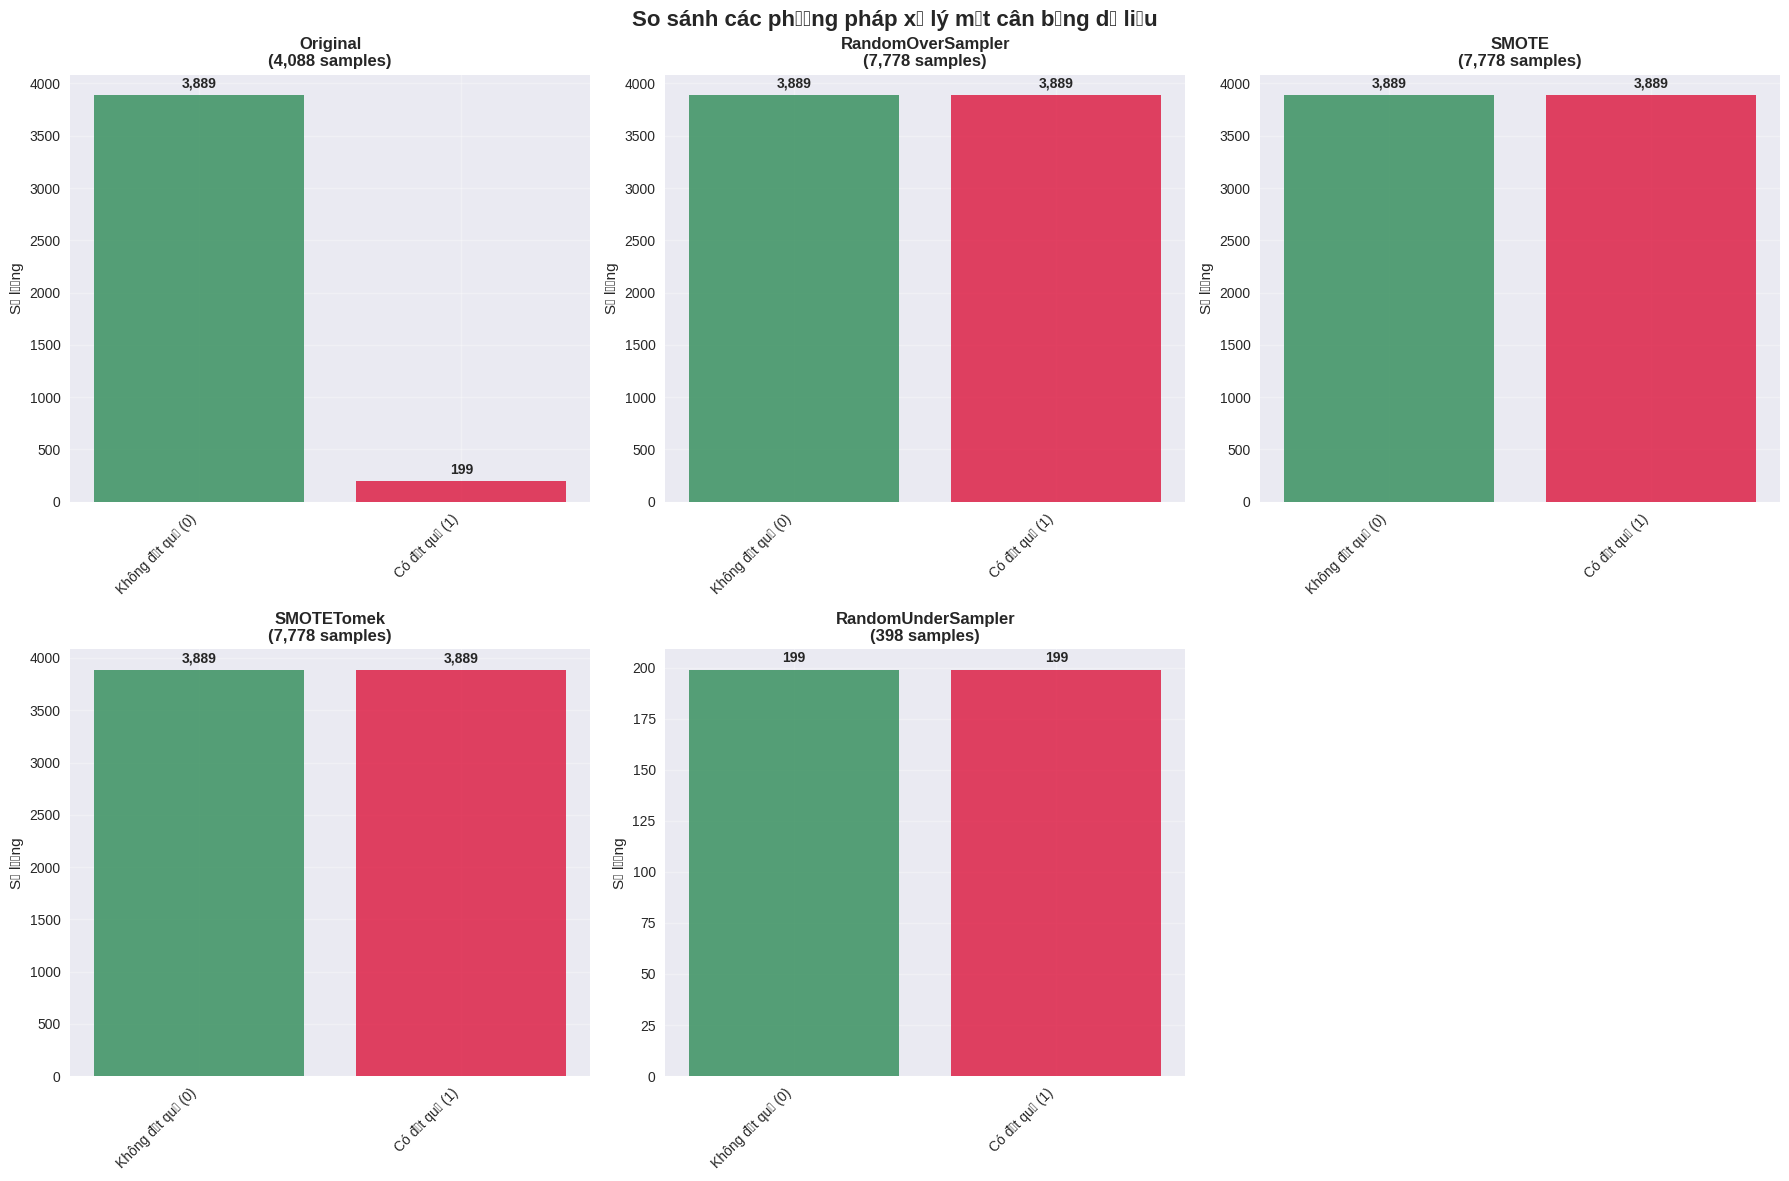

In [10]:
# Biểu đồ so sánh các phương pháp sampling
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('So sánh các phương pháp xử lý mất cân bằng dữ liệu', fontsize=16, fontweight='bold')

axes = axes.flatten()
mauSac = ['#2E8B57', '#DC143C']
nhanNhom = ['Không đột quỵ (0)', 'Có đột quỵ (1)']

for i, (tenPhuongPhap, (X_sampled, y_sampled)) in enumerate(duLieuSampled.items()):
    if i < len(axes):
        phanPhoiTarget = pd.Series(y_sampled).value_counts().sort_index()

        bars = axes[i].bar(range(len(phanPhoiTarget)), phanPhoiTarget.values,
                          color=mauSac, alpha=0.8)

        axes[i].set_title(f'{tenPhuongPhap}\n({len(y_sampled):,} samples)', fontweight='bold')
        axes[i].set_xticks(range(len(phanPhoiTarget)))
        axes[i].set_xticklabels(nhanNhom, rotation=45, ha='right')
        axes[i].set_ylabel('Số lượng')
        axes[i].grid(True, alpha=0.3)

        # Thêm nhãn trên cột
        for bar, value in zip(bars, phanPhoiTarget.values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(phanPhoiTarget.values)*0.01,
                        f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Ẩn subplot thừa
if len(duLieuSampled) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

## 4. XÂY DỰNG VÀ SO SÁNH CÁC MÔ HÌNH

In [25]:
# Định nghĩa các mô hình
print("🤖 ĐỊNH NGHĨA CÁC MÔ HÌNH MACHINE LEARNING:")
print("="*60)

# Định nghĩa các mô hình với conditional import
cacMoHinh = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    # Thêm hai mô hình nữa
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Thêm XGBoost nếu có sẵn
if XGBOOST_AVAILABLE and 'XGBoost' not in cacMoHinh:
    cacMoHinh['XGBoost'] = XGBClassifier(random_state=42, eval_metric='logloss')

# Thêm LightGBM nếu có sẵn
if LIGHTGBM_AVAILABLE and 'LightGBM' not in cacMoHinh:
    cacMoHinh['LightGBM'] = LGBMClassifier(random_state=42, verbose=-1)


print(f"📊 Số lượng mô hình: {len(cacMoHinh)}")
for i, tenMoHinh in enumerate(cacMoHinh.keys(), 1):
    print(f"   {i:2d}. {tenMoHinh}")

# Định nghĩa cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"\n🔄 Cross-validation: {cv.n_splits}-fold StratifiedKFold")

🤖 ĐỊNH NGHĨA CÁC MÔ HÌNH MACHINE LEARNING:
📊 Số lượng mô hình: 10
    1. Logistic Regression
    2. Random Forest
    3. Gradient Boosting
    4. SVM
    5. KNN
    6. Naive Bayes
    7. Decision Tree
    8. AdaBoost
    9. XGBoost
   10. LightGBM

🔄 Cross-validation: 5-fold StratifiedKFold


In [12]:
# Hàm đánh giá mô hình
def danhGiaMoHinh(moHinh, X_train, y_train, X_test, y_test, cv=cv):
    """Đánh giá toàn diện một mô hình"""

    # Cross-validation scores
    cv_accuracy = cross_val_score(moHinh, X_train, y_train, cv=cv, scoring='accuracy')
    cv_precision = cross_val_score(moHinh, X_train, y_train, cv=cv, scoring='precision')
    cv_recall = cross_val_score(moHinh, X_train, y_train, cv=cv, scoring='recall')
    cv_f1 = cross_val_score(moHinh, X_train, y_train, cv=cv, scoring='f1')
    cv_roc_auc = cross_val_score(moHinh, X_train, y_train, cv=cv, scoring='roc_auc')

    # Fit và predict trên test set
    moHinh.fit(X_train, y_train)
    y_pred = moHinh.predict(X_test)
    y_pred_proba = moHinh.predict_proba(X_test)[:, 1] if hasattr(moHinh, 'predict_proba') else None

    # Test scores
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    return {
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_std': cv_accuracy.std(),
        'cv_precision_mean': cv_precision.mean(),
        'cv_precision_std': cv_precision.std(),
        'cv_recall_mean': cv_recall.mean(),
        'cv_recall_std': cv_recall.std(),
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std(),
        'cv_roc_auc_mean': cv_roc_auc.mean(),
        'cv_roc_auc_std': cv_roc_auc.std(),
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'model': moHinh
    }

print("✅ Đã định nghĩa hàm đánh giá mô hình")

✅ Đã định nghĩa hàm đánh giá mô hình


In [13]:
# Đánh giá tất cả mô hình với dữ liệu SMOTE
print("🚀 BẮT ĐẦU ĐÁNH GIÁ TẤT CẢ MÔ HÌNH:")
print("="*60)

# Sử dụng dữ liệu SMOTE (cân bằng tốt nhất)
X_train_smote, y_train_smote = duLieuSampled['SMOTE']

ketQuaDanhGia = {}
bangKetQua = []

for tenMoHinh, moHinh in cacMoHinh.items():
    print(f"\n🔄 Đang đánh giá {tenMoHinh}...")

    try:
        ketQua = danhGiaMoHinh(moHinh, X_train_smote, y_train_smote, X_test_processed, y_test)
        ketQuaDanhGia[tenMoHinh] = ketQua

        # Thêm vào bảng kết quả
        bangKetQua.append({
            'Model': tenMoHinh,
            'CV_Accuracy': f"{ketQua['cv_accuracy_mean']:.4f} ± {ketQua['cv_accuracy_std']:.4f}",
            'CV_Precision': f"{ketQua['cv_precision_mean']:.4f} ± {ketQua['cv_precision_std']:.4f}",
            'CV_Recall': f"{ketQua['cv_recall_mean']:.4f} ± {ketQua['cv_recall_std']:.4f}",
            'CV_F1': f"{ketQua['cv_f1_mean']:.4f} ± {ketQua['cv_f1_std']:.4f}",
            'CV_ROC_AUC': f"{ketQua['cv_roc_auc_mean']:.4f} ± {ketQua['cv_roc_auc_std']:.4f}",
            'Test_Accuracy': f"{ketQua['test_accuracy']:.4f}",
            'Test_Precision': f"{ketQua['test_precision']:.4f}",
            'Test_Recall': f"{ketQua['test_recall']:.4f}",
            'Test_F1': f"{ketQua['test_f1']:.4f}",
            'Test_ROC_AUC': f"{ketQua['test_roc_auc']:.4f}" if ketQua['test_roc_auc'] else 'N/A'
        })

        print(f"   ✅ Hoàn thành - Test F1: {ketQua['test_f1']:.4f}")

    except Exception as e:
        print(f"   ❌ Lỗi: {str(e)}")
        continue

# Tạo DataFrame kết quả
dfKetQua = pd.DataFrame(bangKetQua)
print(f"\n📊 BẢNG KẾT QUẢ TỔNG HỢP:")
print("="*100)
print(dfKetQua.to_string(index=False))

🚀 BẮT ĐẦU ĐÁNH GIÁ TẤT CẢ MÔ HÌNH:

🔄 Đang đánh giá Logistic Regression...
   ✅ Hoàn thành - Test F1: 0.2283

🔄 Đang đánh giá Random Forest...
   ✅ Hoàn thành - Test F1: 0.1067

🔄 Đang đánh giá Gradient Boosting...
   ✅ Hoàn thành - Test F1: 0.1957

🔄 Đang đánh giá SVM...
   ✅ Hoàn thành - Test F1: 0.1983

🔄 Đang đánh giá KNN...
   ✅ Hoàn thành - Test F1: 0.1781

🔄 Đang đánh giá Naive Bayes...
   ✅ Hoàn thành - Test F1: 0.1256

🔄 Đang đánh giá Decision Tree...
   ✅ Hoàn thành - Test F1: 0.1709

🔄 Đang đánh giá AdaBoost...
   ✅ Hoàn thành - Test F1: 0.2689

🔄 Đang đánh giá XGBoost...
   ✅ Hoàn thành - Test F1: 0.1111

🔄 Đang đánh giá LightGBM...
   ✅ Hoàn thành - Test F1: 0.1370

📊 BẢNG KẾT QUẢ TỔNG HỢP:
              Model     CV_Accuracy    CV_Precision       CV_Recall           CV_F1      CV_ROC_AUC Test_Accuracy Test_Precision Test_Recall Test_F1 Test_ROC_AUC
Logistic Regression 0.7903 ± 0.0128 0.7461 ± 0.0120 0.8804 ± 0.0161 0.8076 ± 0.0117 0.8548 ± 0.0116        0.7221         0.1

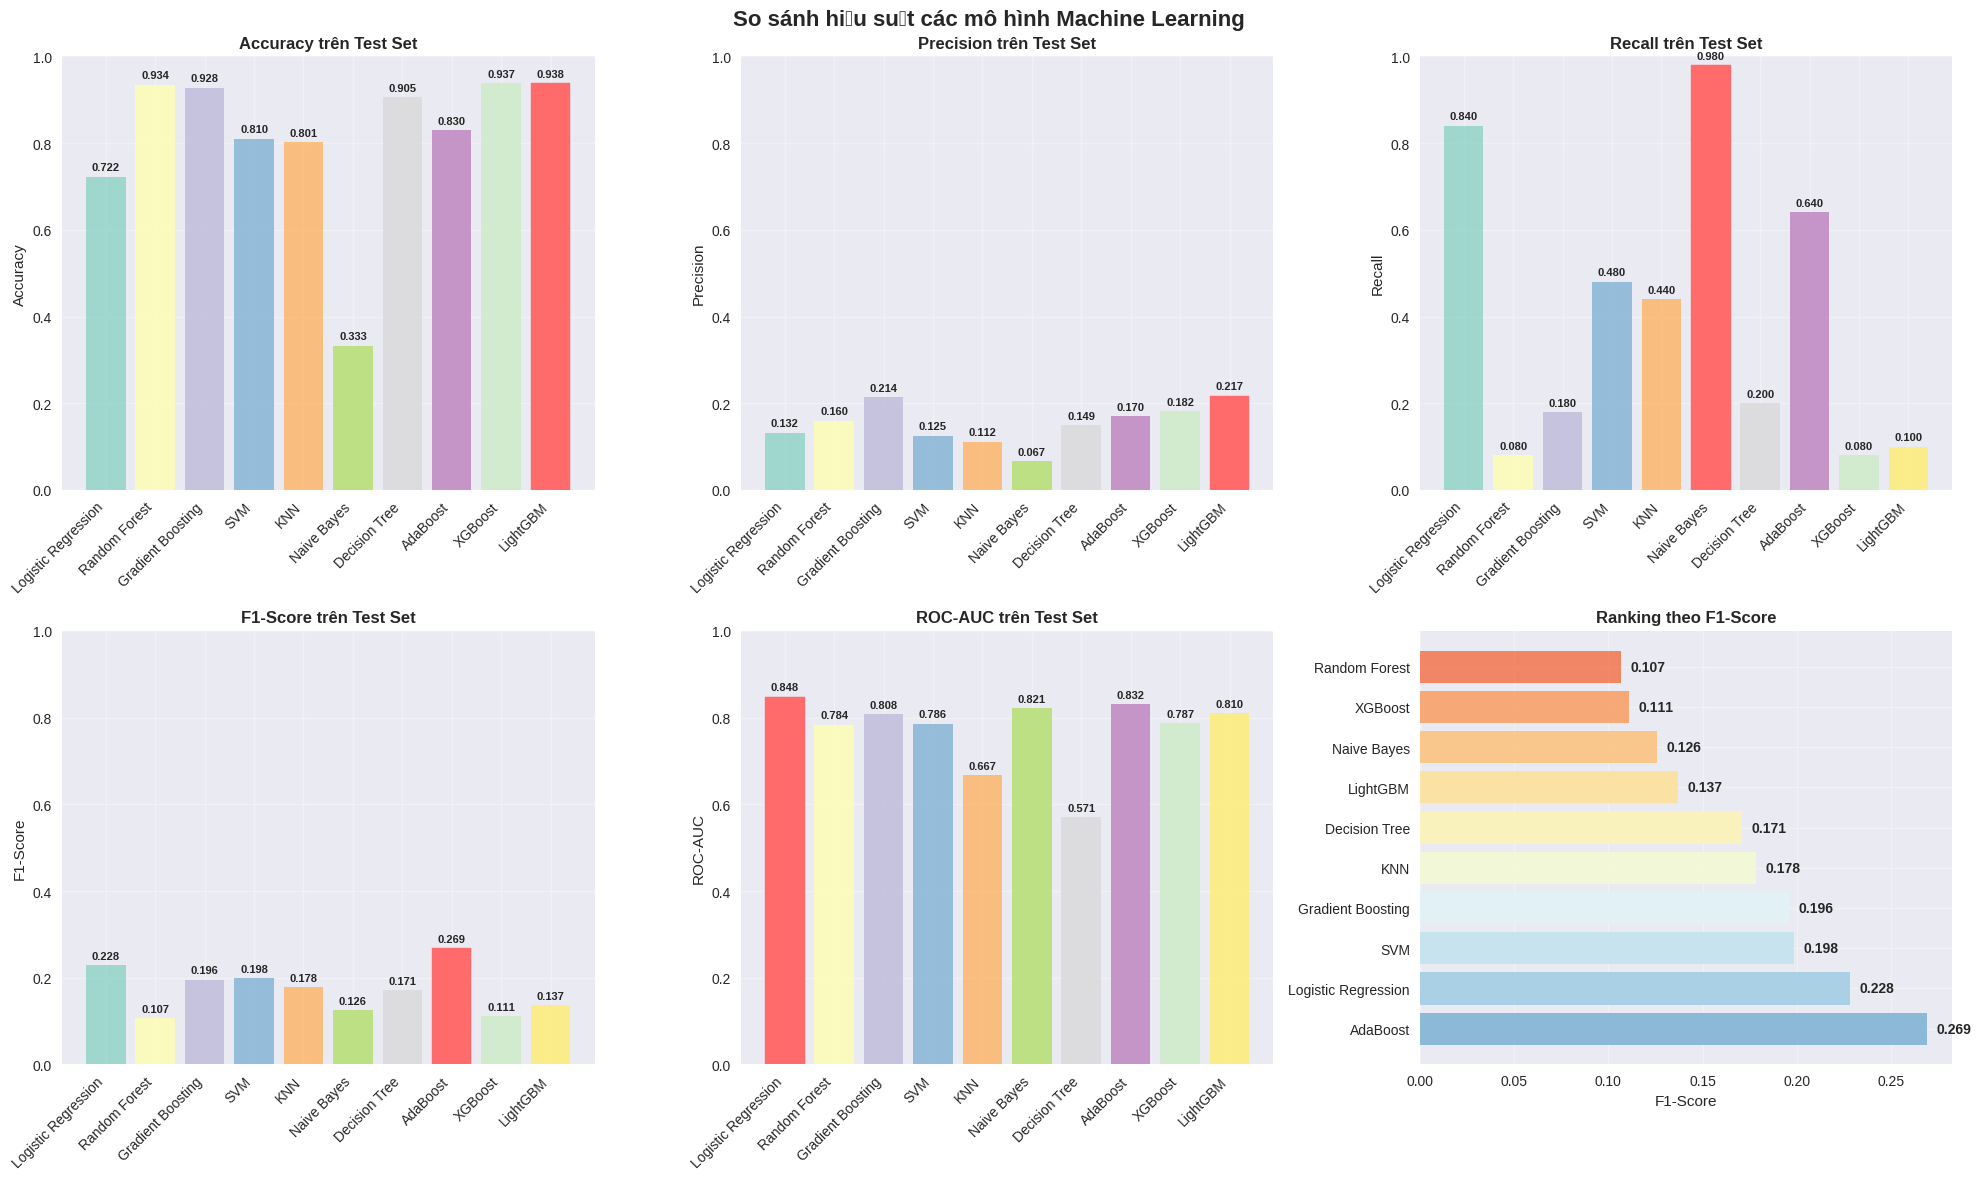

In [14]:
# Biểu đồ so sánh hiệu suất các mô hình
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('So sánh hiệu suất các mô hình Machine Learning', fontsize=16, fontweight='bold')

# Chuẩn bị dữ liệu cho biểu đồ
tenMoHinh = list(ketQuaDanhGia.keys())
cacMetric = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']
tenMetric = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

axes = axes.flatten()

for i, (metric, ten) in enumerate(zip(cacMetric, tenMetric)):
    if i < len(axes):
        giaTriMetric = []
        for moHinh in tenMoHinh:
            giaTriMetric.append(ketQuaDanhGia[moHinh][metric] if ketQuaDanhGia[moHinh][metric] is not None else 0)

        # Tạo biểu đồ cột
        bars = axes[i].bar(range(len(tenMoHinh)), giaTriMetric,
                          color=plt.cm.Set3(np.linspace(0, 1, len(tenMoHinh))), alpha=0.8)

        axes[i].set_title(f'{ten} trên Test Set', fontweight='bold')
        axes[i].set_ylabel(ten)
        axes[i].set_xticks(range(len(tenMoHinh)))
        axes[i].set_xticklabels(tenMoHinh, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(0, 1)

        # Thêm nhãn trên cột
        for bar, value in zip(bars, giaTriMetric):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Highlight mô hình tốt nhất
        bestIdx = np.argmax(giaTriMetric)
        bars[bestIdx].set_color('#FF6B6B')
        bars[bestIdx].set_alpha(1.0)

# Biểu đồ tổng hợp F1-Score
if len(axes) > 5:
    f1Scores = [ketQuaDanhGia[moHinh]['test_f1'] for moHinh in tenMoHinh]
    sortedIndices = np.argsort(f1Scores)[::-1]

    bars = axes[5].barh(range(len(tenMoHinh)),
                       [f1Scores[i] for i in sortedIndices],
                       color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(tenMoHinh))), alpha=0.8)

    axes[5].set_title('Ranking theo F1-Score', fontweight='bold')
    axes[5].set_xlabel('F1-Score')
    axes[5].set_yticks(range(len(tenMoHinh)))
    axes[5].set_yticklabels([tenMoHinh[i] for i in sortedIndices])
    axes[5].grid(True, alpha=0.3)

    # Thêm nhãn
    for bar, idx in zip(bars, sortedIndices):
        axes[5].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                    f'{f1Scores[idx]:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. PHÂN TÍCH MÔ HÌNH TỐT NHẤT

In [15]:
# Xác định mô hình tốt nhất và top 3
print("🏆 XÁC ĐỊNH MÔ HÌNH TỐT NHẤT VÀ TOP 3:")
print("="*60)

# Sắp xếp theo F1-score trên tập test
bangXepHang = []
for tenMoHinh, ketQua in ketQuaDanhGia.items():
    bangXepHang.append({
        'Model': tenMoHinh,
        'F1_Score': ketQua['test_f1'],
        'ROC_AUC': ketQua['test_roc_auc'] if ketQua['test_roc_auc'] else 0,
        'Precision': ketQua['test_precision'],
        'Recall': ketQua['test_recall'],
        'Accuracy': ketQua['test_accuracy']
    })

dfXepHang = pd.DataFrame(bangXepHang).sort_values('F1_Score', ascending=False)

print("📊 TOP 3 MÔ HÌNH TỐT NHẤT (theo F1-Score trên Test Set):")
print(dfXepHang.head(3).round(4).to_string(index=False))

# Lấy mô hình tốt nhất
moHinhTotNhat = dfXepHang.iloc[0]['Model']
ketQuaTotNhat = ketQuaDanhGia[moHinhTotNhat]
modelTotNhat = ketQuaTotNhat['model']

print(f"\n🥇 MÔ HÌNH TỐT NHẤT: {moHinhTotNhat}")
print(f"   • F1-Score: {ketQuaTotNhat['test_f1']:.4f}")
print(f"   • ROC-AUC: {ketQuaTotNhat['test_roc_auc']:.4f}")
print(f"   • Precision: {ketQuaTotNhat['test_precision']:.4f}")
print(f"   • Recall: {ketQuaTotNhat['test_recall']:.4f}")
print(f"   • Accuracy: {ketQuaTotNhat['test_accuracy']:.4f}")

# Lấy danh sách 3 mô hình tốt nhất
top3_models_names = dfXepHang['Model'].head(3).tolist()
print(f"\n🏅 TOP 3 MÔ HÌNH ĐƯỢC CHỌN ĐỂ LƯU: {top3_models_names}")

🏆 XÁC ĐỊNH MÔ HÌNH TỐT NHẤT VÀ TOP 3:
📊 TOP 3 MÔ HÌNH TỐT NHẤT (theo F1-Score trên Test Set):
              Model  F1_Score  ROC_AUC  Precision  Recall  Accuracy
           AdaBoost    0.2689   0.8316     0.1702    0.64    0.8297
Logistic Regression    0.2283   0.8484     0.1321    0.84    0.7221
                SVM    0.1983   0.7859     0.1250    0.48    0.8102

🥇 MÔ HÌNH TỐT NHẤT: AdaBoost
   • F1-Score: 0.2689
   • ROC-AUC: 0.8316
   • Precision: 0.1702
   • Recall: 0.6400
   • Accuracy: 0.8297

🏅 TOP 3 MÔ HÌNH ĐƯỢC CHỌN ĐỂ LƯU: ['AdaBoost', 'Logistic Regression', 'SVM']


In [16]:
# Confusion Matrix và Classification Report
print(f"\n📊 PHÂN TÍCH CHI TIẾT MÔ HÌNH {moHinhTotNhat}:")
print("="*60)

y_pred_best = ketQuaTotNhat['y_pred']
y_pred_proba_best = ketQuaTotNhat['y_pred_proba']

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
print("🔍 CONFUSION MATRIX:")
print(cm)

# Classification Report
print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_best,
                          target_names=['Không đột quỵ', 'Có đột quỵ']))

# Tính các metrics bổ sung
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # = recall
ppv = tp / (tp + fp)  # = precision
npv = tn / (tn + fn)

print(f"\n📈 METRICS BỔ SUNG:")
print(f"   • Sensitivity (Recall): {sensitivity:.4f}")
print(f"   • Specificity: {specificity:.4f}")
print(f"   • Positive Predictive Value (Precision): {ppv:.4f}")
print(f"   • Negative Predictive Value: {npv:.4f}")
print(f"   • True Positives: {tp}")
print(f"   • True Negatives: {tn}")
print(f"   • False Positives: {fp}")
print(f"   • False Negatives: {fn}")


📊 PHÂN TÍCH CHI TIẾT MÔ HÌNH AdaBoost:
🔍 CONFUSION MATRIX:
[[816 156]
 [ 18  32]]

📋 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Không đột quỵ       0.98      0.84      0.90       972
   Có đột quỵ       0.17      0.64      0.27        50

     accuracy                           0.83      1022
    macro avg       0.57      0.74      0.59      1022
 weighted avg       0.94      0.83      0.87      1022


📈 METRICS BỔ SUNG:
   • Sensitivity (Recall): 0.6400
   • Specificity: 0.8395
   • Positive Predictive Value (Precision): 0.1702
   • Negative Predictive Value: 0.9784
   • True Positives: 32
   • True Negatives: 816
   • False Positives: 156
   • False Negatives: 18


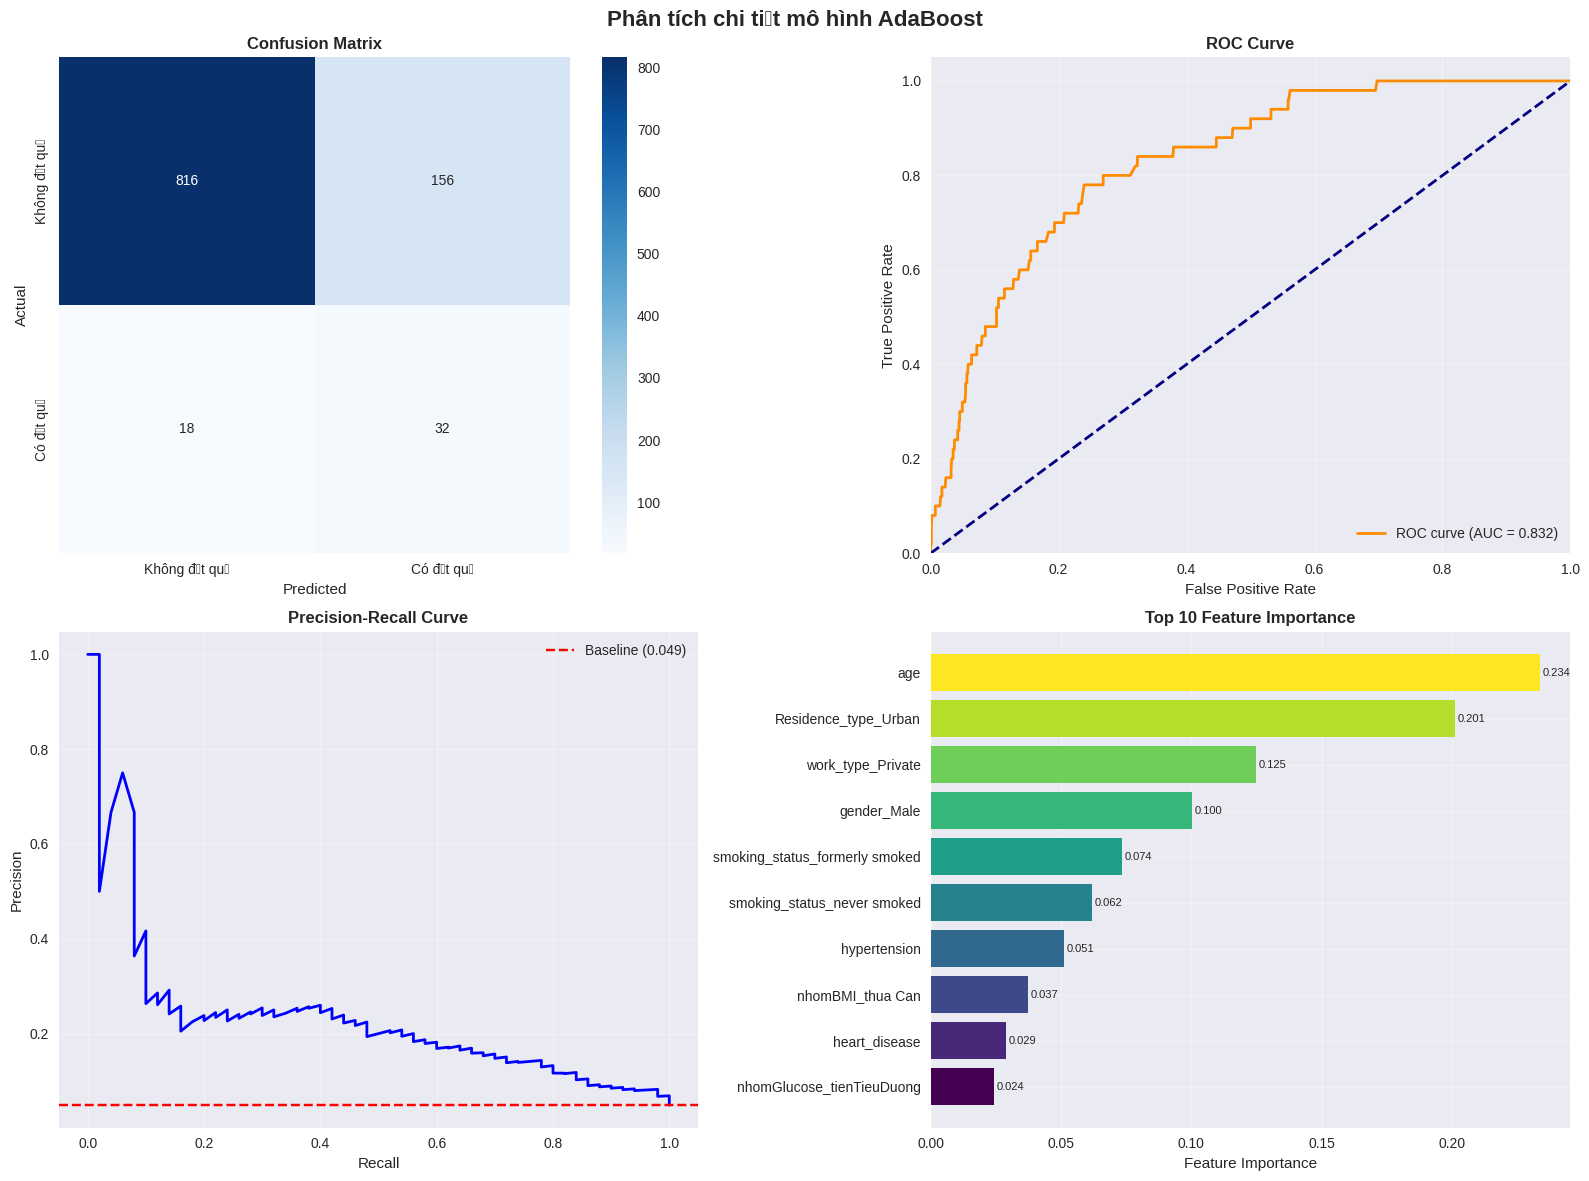

In [17]:
# Vẽ biểu đồ phân tích mô hình tốt nhất
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Phân tích chi tiết mô hình {moHinhTotNhat}', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không đột quỵ', 'Có đột quỵ'],
            yticklabels=['Không đột quỵ', 'Có đột quỵ'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. ROC Curve
if y_pred_proba_best is not None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
    roc_auc = roc_auc_score(y_test, y_pred_proba_best)

    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
                   label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve', fontweight='bold')
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
if y_pred_proba_best is not None:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_best)

    axes[1,0].plot(recall_curve, precision_curve, color='blue', lw=2)
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Precision-Recall Curve', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)

    # Thêm baseline
    baseline = y_test.sum() / len(y_test)
    axes[1,0].axhline(y=baseline, color='red', linestyle='--',
                     label=f'Baseline ({baseline:.3f})')
    axes[1,0].legend()

# 4. Feature Importance (nếu có)
if hasattr(modelTotNhat, 'feature_importances_'):
    feature_importance = modelTotNhat.feature_importances_

    # Lấy top 10 features quan trọng nhất
    top_indices = np.argsort(feature_importance)[-10:]
    top_features = [tenFeaturesSauXuLy[i] if i < len(tenFeaturesSauXuLy) else f'Feature_{i}'
                   for i in top_indices]
    top_importance = feature_importance[top_indices]

    bars = axes[1,1].barh(range(len(top_features)), top_importance,
                         color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features)
    axes[1,1].set_xlabel('Feature Importance')
    axes[1,1].set_title('Top 10 Feature Importance', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

    # Thêm giá trị
    for bar, value in zip(bars, top_importance):
        axes[1,1].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                      f'{value:.3f}', ha='left', va='center', fontsize=8)
else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nkhông khả dụng\ncho mô hình này',
                  ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].set_title('Feature Importance', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. HYPERPARAMETER TUNING CHO MÔ HÌNH TỐT NHẤT

In [18]:
# Hyperparameter tuning cho mô hình tốt nhất
print(f"🔧 HYPERPARAMETER TUNING CHO {moHinhTotNhat}:")
print("="*60)

# Định nghĩa parameter grid cho các mô hình phổ biến
paramGrids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    }
}

# Khởi tạo mô hình cuối cùng bằng mô hình tốt nhất ban đầu
moHinhCuoiCung = modelTotNhat
y_pred_final = y_pred_best
y_pred_proba_final = y_pred_proba_best

if moHinhTotNhat in paramGrids:
    print(f"🔍 Đang tìm kiếm hyperparameters tối ưu cho {moHinhTotNhat}...")

    # Tạo mô hình mới
    if moHinhTotNhat == 'Random Forest':
        baseModel = RandomForestClassifier(random_state=42)
    elif moHinhTotNhat == 'XGBoost' and XGBOOST_AVAILABLE:
        baseModel = XGBClassifier(random_state=42, eval_metric='logloss')
    elif moHinhTotNhat == 'LightGBM' and LIGHTGBM_AVAILABLE:
        baseModel = LGBMClassifier(random_state=42, verbose=-1)
    elif moHinhTotNhat == 'Logistic Regression':
        baseModel = LogisticRegression(random_state=42, max_iter=1000)
    elif moHinhTotNhat == 'SVM':
        baseModel = SVC(random_state=42, probability=True)
    elif moHinhTotNhat == 'AdaBoost':
        baseModel = AdaBoostClassifier(random_state=42)
    else:
        baseModel = modelTotNhat

    # Grid Search với cross-validation
    gridSearch = GridSearchCV(
        baseModel,
        paramGrids[moHinhTotNhat],
        cv=3,  # Giảm số fold để tăng tốc
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    # Fit trên dữ liệu SMOTE
    gridSearch.fit(X_train_smote, y_train_smote)

    # Lấy mô hình tốt nhất
    moHinhTuned = gridSearch.best_estimator_

    print(f"\n✅ Hoàn thành hyperparameter tuning!")
    print(f"🏆 Best parameters: {gridSearch.best_params_}")
    print(f"📊 Best CV F1-score: {gridSearch.best_score_:.4f}")

    # Đánh giá mô hình đã tuned
    y_pred_tuned = moHinhTuned.predict(X_test_processed)
    y_pred_proba_tuned = moHinhTuned.predict_proba(X_test_processed)[:, 1]

    f1_tuned = f1_score(y_test, y_pred_tuned)
    roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
    precision_tuned = precision_score(y_test, y_pred_tuned)
    recall_tuned = recall_score(y_test, y_pred_tuned)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

    print(f"\n📈 HIỆU SUẤT SAU TUNING:")
    print(f"   • F1-Score: {f1_tuned:.4f} (trước: {ketQuaTotNhat['test_f1']:.4f})")
    print(f"   • ROC-AUC: {roc_auc_tuned:.4f} (trước: {ketQuaTotNhat['test_roc_auc']:.4f})")
    print(f"   • Precision: {precision_tuned:.4f} (trước: {ketQuaTotNhat['test_precision']:.4f})")
    print(f"   • Recall: {recall_tuned:.4f} (trước: {ketQuaTotNhat['test_recall']:.4f})")
    print(f"   • Accuracy: {accuracy_tuned:.4f} (trước: {ketQuaTotNhat['test_accuracy']:.4f})")

    # So sánh cải thiện
    caiThienF1 = f1_tuned - ketQuaTotNhat['test_f1']
    caiThienROC = roc_auc_tuned - ketQuaTotNhat['test_roc_auc']

    print(f"\n📊 CẢI THIỆN:")
    print(f"   • F1-Score: {'+' if caiThienF1 > 0 else ''}{caiThienF1:.4f}")
    print(f"   • ROC-AUC: {'+' if caiThienROC > 0 else ''}{caiThienROC:.4f}")

    if caiThienF1 > 0.01:
        print("   ✅ Có cải thiện đáng kể sau tuning!")
        moHinhCuoiCung = moHinhTuned
        y_pred_final = y_pred_tuned
        y_pred_proba_final = y_pred_proba_tuned
    else:
        print("   ⚠️  Cải thiện không đáng kể, sử dụng mô hình gốc")
        moHinhCuoiCung = modelTotNhat
        y_pred_final = y_pred_best
        y_pred_proba_final = y_pred_proba_best
else:
    print(f"⚠️  Không có parameter grid cho {moHinhTotNhat}. Bỏ qua tuning.")

🔧 HYPERPARAMETER TUNING CHO AdaBoost:
🔍 Đang tìm kiếm hyperparameters tối ưu cho AdaBoost...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

✅ Hoàn thành hyperparameter tuning!
🏆 Best parameters: {'learning_rate': 1.0, 'n_estimators': 200}
📊 Best CV F1-score: 0.9336

📈 HIỆU SUẤT SAU TUNING:
   • F1-Score: 0.2615 (trước: 0.2689)
   • ROC-AUC: 0.8348 (trước: 0.8316)
   • Precision: 0.2125 (trước: 0.1702)
   • Recall: 0.3400 (trước: 0.6400)
   • Accuracy: 0.9061 (trước: 0.8297)

📊 CẢI THIỆN:
   • F1-Score: -0.0074
   • ROC-AUC: +0.0032
   ⚠️  Cải thiện không đáng kể, sử dụng mô hình gốc


## 7. Phân tích chi tiết mô hình cuối cùng

### 7.1 Đánh giá toàn diện

In [19]:
# Tạo báo cáo chi tiết cho mô hình cuối cùng
print("🎯 BÁO CÁO CHI TIẾT MÔ HÌNH CUỐI CÙNG")
print("=" * 50)
print(f"Mô hình được chọn: {type(moHinhCuoiCung).__name__}")
print(f"Tham số: {moHinhCuoiCung.get_params()}")

# Ma trận nhầm lẫn chi tiết
from sklearn.metrics import confusion_matrix, classification_report

cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print(f"\n📊 MA TRẬN NHẦM LẪN:")
print(f"   True Negatives (TN): {tn}")
print(f"   False Positives (FP): {fp}")
print(f"   False Negatives (FN): {fn}")
print(f"   True Positives (TP): {tp}")

# Các chỉ số chi tiết
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)  # Precision
npv = tn / (tn + fn)

print(f"\n📈 CÁC CHỈ SỐ CHI TIẾT:")
print(f"   Sensitivity (Recall): {sensitivity:.4f}")
print(f"   Specificity: {specificity:.4f}")
print(f"   Positive Predictive Value (PPV): {ppv:.4f}")
print(f"   Negative Predictive Value (NPV): {npv:.4f}")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_final, target_names=['Không đột quỵ', 'Đột quỵ']))

🎯 BÁO CÁO CHI TIẾT MÔ HÌNH CUỐI CÙNG
Mô hình được chọn: AdaBoostClassifier
Tham số: {'algorithm': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': 42}

📊 MA TRẬN NHẦM LẪN:
   True Negatives (TN): 816
   False Positives (FP): 156
   False Negatives (FN): 18
   True Positives (TP): 32

📈 CÁC CHỈ SỐ CHI TIẾT:
   Sensitivity (Recall): 0.6400
   Specificity: 0.8395
   Positive Predictive Value (PPV): 0.1702
   Negative Predictive Value (NPV): 0.9784

📋 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Không đột quỵ       0.98      0.84      0.90       972
      Đột quỵ       0.17      0.64      0.27        50

     accuracy                           0.83      1022
    macro avg       0.57      0.74      0.59      1022
 weighted avg       0.94      0.83      0.87      1022



### 7.2 Visualizations cuối cùng

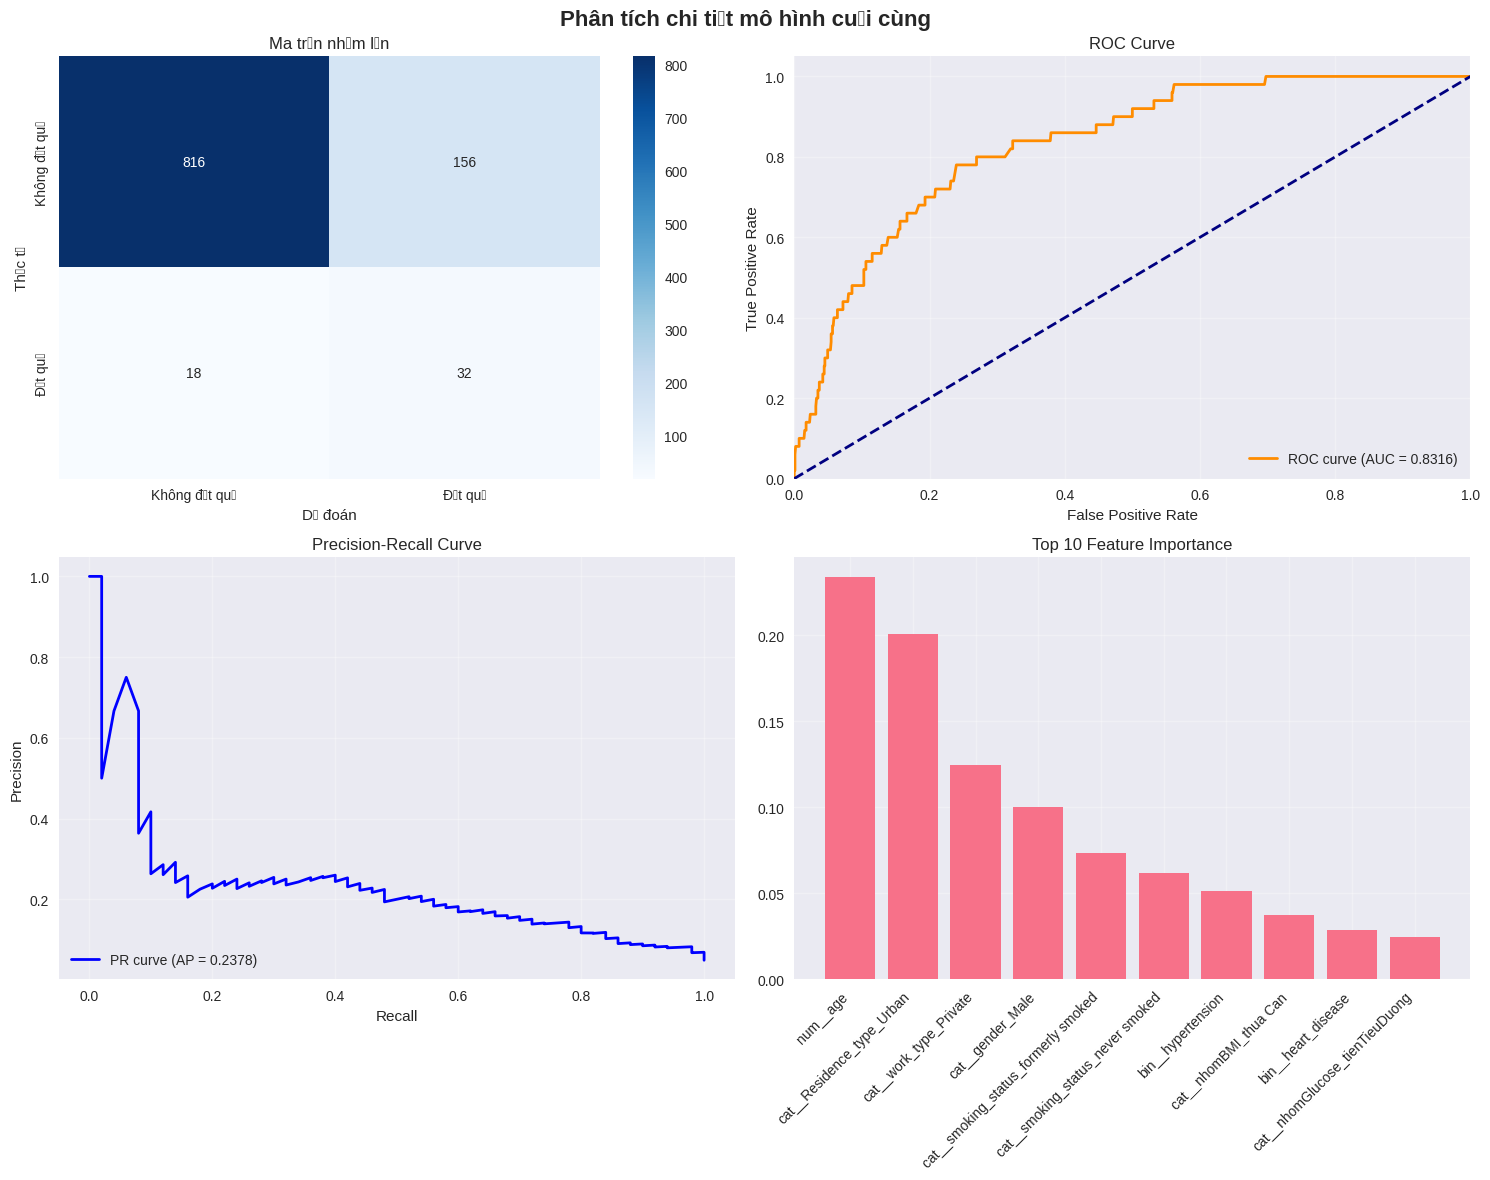

In [20]:
# Tạo các biểu đồ cuối cùng
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Phân tích chi tiết mô hình cuối cùng', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không đột quỵ', 'Đột quỵ'],
            yticklabels=['Không đột quỵ', 'Đột quỵ'],
            ax=axes[0,0])
axes[0,0].set_title('Ma trận nhầm lẫn')
axes[0,0].set_xlabel('Dự đoán')
axes[0,0].set_ylabel('Thực tế')

# 2. ROC Curve
from sklearn.metrics import roc_curve, auc
# Check if y_pred_proba_final is 2D, if so take the second column (probability of class 1)
if y_pred_proba_final.ndim > 1:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final[:, 1])
else:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)

roc_auc = auc(fpr, tpr)

axes[0,1].plot(fpr, tpr, color='darkorange', lw=2,
               label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
# Check if y_pred_proba_final is 2D, if so take the second column (probability of class 1)
if y_pred_proba_final.ndim > 1:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_final[:, 1])
    avg_precision = average_precision_score(y_test, y_pred_proba_final[:, 1])
else:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_final)
    avg_precision = average_precision_score(y_test, y_pred_proba_final)


axes[1,0].plot(recall_curve, precision_curve, color='blue', lw=2,
               label=f'PR curve (AP = {avg_precision:.4f})')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].legend(loc="lower left")
axes[1,0].grid(True, alpha=0.3)

# 4. Feature Importance (nếu có)
if hasattr(moHinhCuoiCung, 'feature_importances_'):
    # Lấy tên features từ preprocessor sau khi fit
    # Use get_feature_names_out from the fitted ColumnTransformer
    try:
        feature_names_out = boXuLyDuLieu.get_feature_names_out()
    except AttributeError:
         # Fallback for older scikit-learn versions
        feature_names_out = []
        for name, transformer, cols in boXuLyDuLieu.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_out.extend(transformer.get_feature_names_out(cols))
            elif hasattr(transformer, 'get_feature_names'):
                 feature_names_out.extend(transformer.get_feature_names(cols))
            else:
                feature_names_out.extend(cols) # Fallback to original column names if no method available


    importances = moHinhCuoiCung.feature_importances_
    # Ensure importances and feature_names_out have the same length
    if len(importances) == len(feature_names_out):
        indices = np.argsort(importances)[::-1][:10]  # Top 10

        axes[1,1].bar(range(len(indices)), importances[indices])
        axes[1,1].set_title('Top 10 Feature Importance')
        axes[1,1].set_xticks(range(len(indices)))
        axes[1,1].set_xticklabels([feature_names_out[i] for i in indices], rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Không thể hiển thị Feature Importance.\nSố lượng đặc trưng không khớp.',
                       ha='center', va='center', transform=axes[1,1].transAxes,
                       fontsize=10)
        axes[1,1].set_title('Feature Importance')

else:
    axes[1,1].text(0.5, 0.5, 'Feature Importance\nkhông khả dụng\ncho mô hình này',
                   ha='center', va='center', transform=axes[1,1].transAxes,
                   fontsize=12)
    axes[1,1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

### 7.3 Phân tích SHAP (nếu có thể)

🔍 PHÂN TÍCH SHAP


PermutationExplainer explainer: 101it [00:25,  2.61it/s]


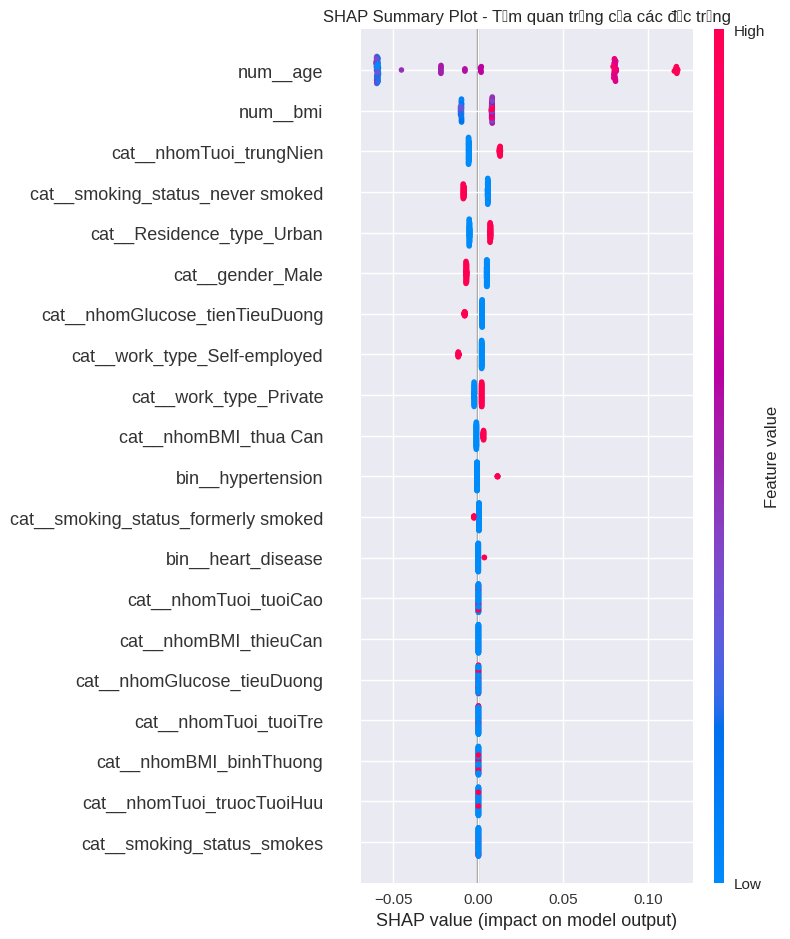

✅ Phân tích SHAP hoàn thành


In [21]:
# Thử phân tích SHAP nếu có thể
try:
    import shap

    print("🔍 PHÂN TÍCH SHAP")
    print("=" * 30)

    # Lấy tên features từ preprocessor sau khi fit
    # Use get_feature_names_out from the fitted ColumnTransformer
    try:
        feature_names_out = boXuLyDuLieu.get_feature_names_out()
    except AttributeError:
         # Fallback for older scikit-learn versions
        feature_names_out = []
        for name, transformer, cols in boXuLyDuLieu.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_out.extend(transformer.get_feature_names_out(cols))
            elif hasattr(transformer, 'get_feature_names'):
                 feature_names_out.extend(transformer.get_feature_names(cols))
            else:
                feature_names_out.extend(cols) # Fallback to original column names if no method available


    # Tạo explainer
    if hasattr(moHinhCuoiCung, 'predict_proba'):
        # Use the processed test data for the explainer
        explainer = shap.Explainer(moHinhCuoiCung.predict_proba, X_test_processed[:100], feature_names=feature_names_out)
        shap_values = explainer(X_test_processed[:100])

        # Summary plot
        plt.figure(figsize=(10, 6))
        # Use the feature names obtained from the preprocessor
        shap.summary_plot(shap_values[:,:,1], X_test_processed[:100],
                         feature_names=feature_names_out, show=False)
        plt.title('SHAP Summary Plot - Tầm quan trọng của các đặc trưng')
        plt.tight_layout()
        plt.show()

        print("✅ Phân tích SHAP hoàn thành")
    else:
        print("⚠️  Mô hình không hỗ trợ predict_proba cho SHAP")

except ImportError:
    print("⚠️  SHAP không được cài đặt. Bỏ qua phân tích SHAP.")
except Exception as e:
    print(f"⚠️  Lỗi khi chạy SHAP: {str(e)}")

## 8. Kết luận và đề xuất

### 8.1 Tóm tắt kết quả

In [22]:
# Tóm tắt kết quả cuối cùng
print("🎯 TÓM TẮT KẾT QUẢ CUỐI CÙNG")
print("=" * 50)

print(f"📊 Mô hình được chọn: {type(moHinhCuoiCung).__name__}")
print(f"📈 F1-Score: {f1_score(y_test, y_pred_final):.4f}")

# Check dimensions of y_pred_proba_final before indexing
if y_pred_proba_final.ndim > 1:
    roc_auc_final = roc_auc_score(y_test, y_pred_proba_final[:, 1])
else:
    roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)

print(f"📈 ROC-AUC: {roc_auc_final:.4f}")
print(f"📈 Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"📈 Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"📈 Recall: {recall_score(y_test, y_pred_final):.4f}")

# Tính toán sensitivity và specificity
from sklearn.metrics import confusion_matrix
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Recall
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0


print(f"\n🎯 HIỆU SUẤT TRÊN TỪNG NHÓM:")
print(f"   • Sensitivity (phát hiện đột quỵ): {sensitivity:.4f}")
print(f"   • Specificity (loại trừ không đột quỵ): {specificity:.4f}")

print(f"\n💡 ĐÁNH GIÁ TỔNG QUAN:")
if f1_score(y_test, y_pred_final) > 0.7:
    print("   ✅ Mô hình có hiệu suất tốt")
elif f1_score(y_test, y_pred_final) > 0.6:
    print("   ⚠️  Mô hình có hiệu suất trung bình")
else:
    print("   ❌ Mô hình cần cải thiện")

if sensitivity > 0.7:
    print("   ✅ Khả năng phát hiện đột quỵ tốt")
else:
    print("   ⚠️  Cần cải thiện khả năng phát hiện đột quỵ")

if specificity > 0.7:
    print("   ✅ Khả năng loại trừ không đột quỵ tốt")
else:
    print("   ⚠️  Cần cải thiện khả năng loại trừ không đột quỵ")

🎯 TÓM TẮT KẾT QUẢ CUỐI CÙNG
📊 Mô hình được chọn: AdaBoostClassifier
📈 F1-Score: 0.2689
📈 ROC-AUC: 0.8316
📈 Accuracy: 0.8297
📈 Precision: 0.1702
📈 Recall: 0.6400

🎯 HIỆU SUẤT TRÊN TỪNG NHÓM:
   • Sensitivity (phát hiện đột quỵ): 0.6400
   • Specificity (loại trừ không đột quỵ): 0.8395

💡 ĐÁNH GIÁ TỔNG QUAN:
   ❌ Mô hình cần cải thiện
   ⚠️  Cần cải thiện khả năng phát hiện đột quỵ
   ✅ Khả năng loại trừ không đột quỵ tốt


### 8.2 Lưu mô hình

In [23]:
# Lưu mô hình và preprocessor
import joblib
import os

# Tạo thư mục models nếu chưa có
models_dir = '/content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models'
os.makedirs(models_dir, exist_ok=True)

# Lưu mô hình cuối cùng
model_path = os.path.join(models_dir, 'moHinhDotQuy_final.pkl')
joblib.dump(moHinhCuoiCung, model_path)

# Lưu preprocessor
preprocessor_path = os.path.join(models_dir, 'preprocessor.pkl')
# Use the correct variable name 'boXuLyDuLieu' instead of 'preprocessor'
joblib.dump(boXuLyDuLieu, preprocessor_path)

# Lưu thông tin mô hình
# Get feature names from the fitted preprocessor
try:
    feature_names_out = boXuLyDuLieu.get_feature_names_out()
except AttributeError:
     # Fallback for older scikit-learn versions
    feature_names_out = []
    for name, transformer, cols in boXuLyDuLieu.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names_out.extend(transformer.get_feature_names_out(cols))
        elif hasattr(transformer, 'get_feature_names'):
             feature_names_out.extend(transformer.get_feature_names(cols))
        else:
            feature_names_out.extend(cols) # Fallback to original column names if no method available


model_info = {
    'model_name': type(moHinhCuoiCung).__name__,
    'f1_score': f1_score(y_test, y_pred_final),
    # Check dimensions of y_pred_proba_final before indexing
    'roc_auc': roc_auc_score(y_test, y_pred_proba_final[:, 1]) if y_pred_proba_final.ndim > 1 else roc_auc_score(y_test, y_pred_proba_final),
    'accuracy': accuracy_score(y_test, y_pred_final),
    'precision': precision_score(y_test, y_pred_final),
    'recall': recall_score(y_test, y_pred_final),
    # Recalculate sensitivity and specificity here as they might not be defined
    'sensitivity': recall_score(y_test, y_pred_final), # Sensitivity is the same as Recall
    'specificity': (confusion_matrix(y_test, y_pred_final).ravel()[0] /
                    (confusion_matrix(y_test, y_pred_final).ravel()[0] + confusion_matrix(y_test, y_pred_final).ravel()[1])
                   ) if (confusion_matrix(y_test, y_pred_final).ravel()[0] + confusion_matrix(y_test, y_pred_final).ravel()[1]) > 0 else 0, # Specificity
    'feature_names': feature_names_out, # Use the corrected feature names
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

info_path = os.path.join(models_dir, 'model_info.pkl')
joblib.dump(model_info, info_path)

print(f"✅ Đã lưu mô hình tại: {model_path}")
print(f"✅ Đã lưu preprocessor tại: {preprocessor_path}")
print(f"✅ Đã lưu thông tin mô hình tại: {info_path}")

✅ Đã lưu mô hình tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/moHinhDotQuy_final.pkl
✅ Đã lưu preprocessor tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/preprocessor.pkl
✅ Đã lưu thông tin mô hình tại: /content/drive/MyDrive/PHÂN TÍCH DỮ LIỆU /models/model_info.pkl


### 8.3 Đề xuất cải thiện

In [24]:
print("💡 ĐỀ XUẤT CẢI THIỆN")
print("=" * 30)

print("🔍 1. Thu thập thêm dữ liệu:")
print("   • Tăng số lượng mẫu đột quỵ để cân bằng dataset")
print("   • Thu thập thêm các đặc trưng y tế quan trọng")
print("   • Dữ liệu theo dõi dài hạn")

print("\n🛠️  2. Kỹ thuật cải thiện mô hình:")
print("   • Thử các thuật toán ensemble khác (Voting, Stacking)")
print("   • Feature engineering nâng cao")
print("   • Hyperparameter tuning sâu hơn với Bayesian Optimization")

print("\n📊 3. Đánh giá và validation:")
print("   • Cross-validation với nhiều fold hơn")
print("   • Validation trên dataset độc lập")
print("   • Phân tích bias và fairness")

print("\n🏥 4. Ứng dụng thực tế:")
print("   • Tích hợp vào hệ thống y tế")
print("   • Tạo dashboard theo dõi real-time")
print("   • Đào tạo nhân viên y tế sử dụng")

print("\n✅ HOÀN THÀNH NOTEBOOK 03: XÂY DỰNG VÀ ĐÁNH GIÁ MÔ HÌNH MACHINE LEARNING")

💡 ĐỀ XUẤT CẢI THIỆN
🔍 1. Thu thập thêm dữ liệu:
   • Tăng số lượng mẫu đột quỵ để cân bằng dataset
   • Thu thập thêm các đặc trưng y tế quan trọng
   • Dữ liệu theo dõi dài hạn

🛠️  2. Kỹ thuật cải thiện mô hình:
   • Thử các thuật toán ensemble khác (Voting, Stacking)
   • Feature engineering nâng cao
   • Hyperparameter tuning sâu hơn với Bayesian Optimization

📊 3. Đánh giá và validation:
   • Cross-validation với nhiều fold hơn
   • Validation trên dataset độc lập
   • Phân tích bias và fairness

🏥 4. Ứng dụng thực tế:
   • Tích hợp vào hệ thống y tế
   • Tạo dashboard theo dõi real-time
   • Đào tạo nhân viên y tế sử dụng

✅ HOÀN THÀNH NOTEBOOK 03: XÂY DỰNG VÀ ĐÁNH GIÁ MÔ HÌNH MACHINE LEARNING
